In [1]:
import torch 
import torch.nn as nn
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt

/Users/ant-lion/Desktop/Dev-learning/PyTorch-nn-Tinkering/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LLama 3.2 1b


In [2]:

model_hf = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")

sd = model_hf.state_dict()

In [3]:
# for k, v in sd.items():
#     k_split = k.split(".")
#     if k_split[1] == "layers" and k_split[2] == "0":
#         print(k, v.shape)

model_hf

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

### PyTorch playground


In [4]:
from dataclasses import dataclass

@dataclass
class Llama1b:
    block_size = 2048
    vocab_size = 128256
    layers = 16
    attn_heads = 16
    n_embd = 2048

#### Layer Norms


**RMSNorm**


_Variables_

- y (gamma): A learnable scale parameter
- $\epsilon$: A small constant (used for stability)
- n: The number of features in the layer
- x: The input vector

_Equation_\
 $y = \frac{x}{\sqrt{\frac{1}{n}\sum_{i=1}^{n} x_i^2 + \epsilon}} \cdot \gamma$


In [64]:
hidden_size = Llama1b.n_embd
hidden_states = torch.randn(size=(hidden_size,))
hidden_states

tensor([ 0.3528,  0.4742, -1.7647,  ...,  0.5914, -0.2007, -0.4640])

In [61]:
weight = nn.Parameter(torch.ones(hidden_size))
variance_epsilon = 1e-6

In [62]:
input_dtype = hidden_states.dtype
hidden_states = hidden_states.to(torch.float32)
variance = hidden_states.pow(2).mean(-1, keepdim=True)
hidden_states = hidden_states * torch.rsqrt(variance + variance_epsilon)

In [65]:
torch.rsqrt(variance)

tensor([0.9502])

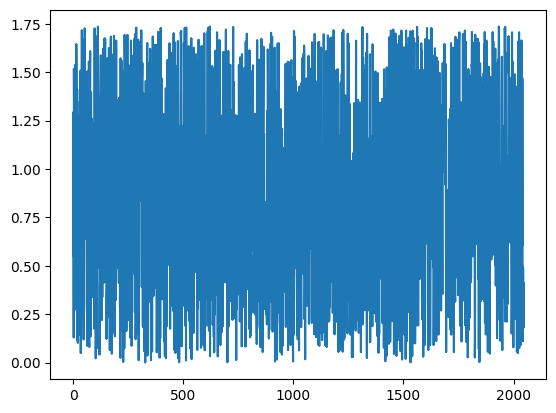

In [56]:
plt.plot(norm_hs)

In [13]:
print("RMSNorm Output")
print(weight * hidden_states.to(input_dtype))

RMSNorm Output
tensor([ 0.0392, -0.8223,  1.1055,  ..., -0.5769, -0.4740,  0.0477],
       grad_fn=<MulBackward0>)


#### Positional Embeddings


In [68]:
import torch
import torch.nn as nn

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len, device="cpu"):
        super(RotaryPositionalEmbedding, self).__init__()

        # Create a rotation matrix.
        self.rotation_matrix = torch.zeros(d_model, d_model, device=torch.device(device))
        for i in range(d_model):
            for j in range(d_model):
                self.rotation_matrix[i, j] = torch.cos(i * j * 0.01)

        # Create a positional embedding matrix.
        self.positional_embedding = torch.zeros(max_seq_len, d_model, device=torch.device(device))
        for i in range(max_seq_len):
            for j in range(d_model):
                self.positional_embedding[i, j] = torch.cos(i * j * 0.01)

    def forward(self, x):
        """
        Args:
            x: A tensor of shape (batch_size, seq_len, d_model).

        Returns:
            A tensor of shape (batch_size, seq_len, d_model).
        """

        # Add the positional embedding to the input tensor.
        x += self.positional_embedding

        # Apply the rotation matrix to the input tensor.
        x = torch.matmul(x, self.rotation_matrix)

        return x
        

**Linear Transformations**


In [71]:
a_mat = torch.tensor([[1,2],[3,3]])
b_vec = torch.tensor([-1,2])
b_vec_trans = a_mat@b_vec

**Function to plot orignal and tranformation vectors**


In [100]:
def plot_vector_tranformation(vector:torch.Tensor, transformation:torch.Tensor):
    plt.figure()
    plt.quiver(*torch.tensor([0,0]), *vector, angles='xy', scale_units='xy', scale=1, color='r')
    plt.quiver(*torch.tensor([0,0]), *transformation, angles='xy', scale_units='xy', scale=1, color='b')

    all_vectors = torch.cat((vector.unsqueeze(0), transformation.unsqueeze(0)))
    x_min, x_max = all_vectors[:, 0].min().item(), all_vectors[:, 0].max().item()
    y_min, y_max = all_vectors[:, 1].min().item(), all_vectors[:, 1].max().item()

    # Set limits and labels
    plt.xlim(x_min - 2, x_max + 2)  # Adding some padding
    plt.ylim(y_min - 2, y_max + 2)  # Adding some padding
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Vector Plot')
    plt.grid()
    plt.axhline(0, color='black', linewidth=2, ls='--')  # Bold horizontal line
    plt.axvline(0, color='black', linewidth=2, ls='--')  # Bold vertical line


    # Show the plot
    plt.show()

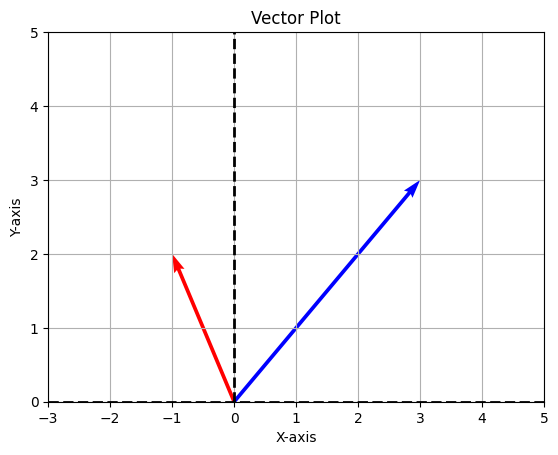

In [101]:
plot_vector_tranformation(b_vec, b_vec_trans)

**Rotational Transformation**


**basic**


In [90]:
import numpy as np
theta = 50_000
m = 1

rotational_mat = torch.Tensor([
    [np.cos(m*theta), np.sin(m*theta)],
    [-np.sin(m*theta), np.cos(m*theta)]
    ])
a_vec = torch.Tensor([1,2])
a_vec_rotated = rotational_mat@a_vec

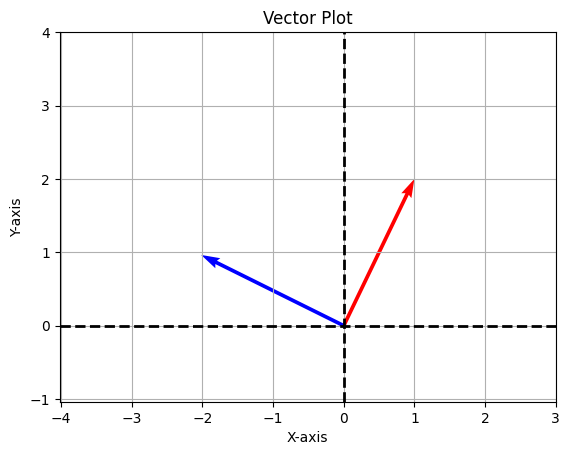

In [102]:
plot_vector_tranformation(a_vec, a_vec_rotated)

**RoPE**
